### Parameter Selection for Adiabatic Extended Phase-Space Simulations

- **System**: alanine dipeptide in vacuum
- **Force field**: AMBER ff03
- **Constraints**: Bonds to hydrogen atoms
- **Hydrogen mass repartitioning**: 3 Da
- **Phase-space extension**: Circular dynamical variables $\phi_s$ and $\psi_s$ attached to backbone dihedrals $\phi({\bf r})$ and $\psi({\bf r})$, respectively

This example demonstrates how to select appropriate parameter values for adiabatic simulations involving dynamical variables (DVs) harmonically attached to collective variables (CVs), as in the formula:

$$
\begin{align}
U_{\rm xs}({\bf r}, {\bf s}) = U({\bf r}) + \sum_{i=1}^{n} \frac{1}{2} \kappa_{q_i} \left[s_i - q_i({\bf r})\right]^2
\end{align}
$$

where $U({\bf r})$ is the potential energy of the system, $q_i({\bf r})$ is the $i$-th collective variable, and $s_i$ is the $i$-th dynamical variable.

For proper adiabatic decoupling, the DV masses must be large compared to the CV effective masses ($m_{s} \gg m_{q}^{\rm eff}$), creating an approximation where the CV behaves as if attached to a fixed body at any instant of time.

In [1]:
import io
from copy import deepcopy

import cvpack
import numpy as np
import openmm as mm
import pandas as pd
from cvpack import reporting
from matplotlib import pyplot as plt
from openmm import app, unit

In [2]:
pdb = app.PDBFile("alanine-dipeptide.pdb")
physical_system = app.ForceField("amber03.xml").createSystem(
    pdb.topology,
    nonbondedCutoff=1.0 * unit.nanometer,
    switchDistance=0.8 * unit.nanometer,
    constraints=app.HBonds,
    hydrogenMass=3 * unit.dalton,
)
platform = mm.Platform.getPlatformByName("Reference")

#### Collective Variables

Our collective variables are the angles $\phi$ and $\psi$, corresponding to backbone dihedrals $C{-}N{-}C_{\alpha}{-}C$ and $N{-}C_{\alpha}{-}C{-}N$, respectively.

In [3]:
backbone_atoms = [
    atom.index for atom in pdb.topology.atoms() if atom.name in ["C", "CA", "N"]
]
phi = cvpack.Torsion(*backbone_atoms[0:4], name="phi")
psi = cvpack.Torsion(*backbone_atoms[1:5], name="psi")

#### Preliminary Simulation

We need to select appropriate values for the force constants $\kappa_{\phi}$ and $\kappa_{\psi}$ and masses $m_{\phi_s}$ and $m_{\psi_s}$ of the CV-DV pairs.

For this, we run a preliminary simulation to estimate the effective masses of the collective variables. The effective mass $m_{q}^{\rm eff}$ characterizes the inertia of the CV motion. It changes with the system configuration according to the following formula:

$$m_{q}^{\rm eff}({\bf r}) = \left[\sum_{i=1}^{N} \frac{1}{m_i} \left\| \frac{\partial q}{\partial {\bf r}_i} \right\|^2\right]^{-1}$$

where $\bf r$ is the system configuration, $q=q({\bf r})$ is the value of the CV, and ${\bf r}_i$ is the position of the $i$-th atom.



In [4]:
pre_system = deepcopy(physical_system)
zero_meta_cv = cvpack.MetaCollectiveVariable("0", [phi, psi], unit.kilojoule_per_mole)
zero_meta_cv.addToSystem(pre_system)
seed = 56745
integrator = mm.LangevinIntegrator(
    300 * unit.kelvin, 1.0 / unit.picosecond, 2 * unit.femtoseconds
)
integrator.setRandomNumberSeed(seed)
pre_simulation = mm.app.Simulation(pdb.topology, pre_system, integrator)
stream = io.StringIO()
pre_simulation.reporters.append(
    reporting.StateDataReporter(
        stream,
        10,
        step=True,
        time=True,
        writers=[
            cvpack.reporting.MetaCVWriter(
                zero_meta_cv, values=["phi", "psi"], emasses=["phi", "psi"]
            )
        ],
    )
)
pre_simulation.context.setPositions(pdb.positions)
pre_simulation.context.setVelocitiesToTemperature(300 * unit.kelvin, seed)
pre_simulation.step(10000)
stream.seek(0)
pre_data = pd.read_csv(stream)

#### Effective Mass Analysis

We need a representative effective mass for parameter selection. We use the 90th percentile of the effective mass distribution in the preliminary simulation. This is a robust choice because of the low sensitivity to extreme outliers.

In [5]:
mass_unit = unit.dalton * (unit.nanometer / unit.radian) ** 2

def get_emass_q90(data: pd.DataFrame, angle: str) -> unit.Quantity:
    return np.quantile(
        data[f"emass[{angle}] ({mass_unit.get_symbol()})"], 0.9
    ) * mass_unit

emass = {
    "phi": get_emass_q90(pre_data, "phi"),
    "psi": get_emass_q90(pre_data, "psi"),
}

f"Effective masses: {emass}"

"Effective masses: {'phi': 0.040415649567635874 nm**2 Da/(rad**2), 'psi': 0.04644734827565988 nm**2 Da/(rad**2)}"

#### Trajectory Visualization

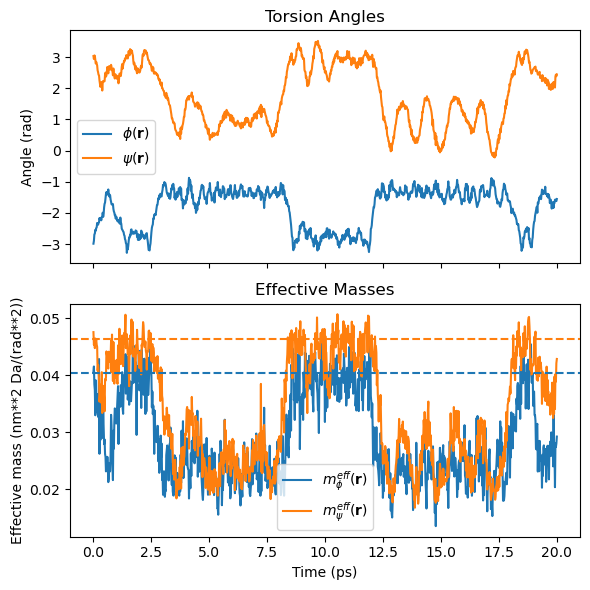

In [6]:
mass_unit_symbol = (unit.dalton * (unit.nanometer / unit.radian) ** 2).get_symbol()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

# Top: Phi and Psi angles
for angle in ["phi", "psi"]:
    ax1.plot(
        pre_data["Time (ps)"],
        np.unwrap(pre_data[f"{angle} (rad)"]),
        label=rf"$\{angle}({{\bf r}})$",
    )
ax1.set_ylabel("Angle (rad)")
ax1.legend()
ax1.set_title("Torsion Angles")

# Bottom: Effective masses
for angle in ["phi", "psi"]:
    ax2.plot(
        pre_data["Time (ps)"],
        pre_data[f"emass[{angle}] ({mass_unit_symbol})"],
        label=rf"$m^{{eff}}_{{\{angle}}}({{\bf r}})$",
    )
ax2.axhline(emass["phi"].value_in_unit(mass_unit), color='C0', linestyle='--')
ax2.axhline(emass["psi"].value_in_unit(mass_unit), color='C1', linestyle='--')
ax2.set_xlabel("Time (ps)")
ax2.set_ylabel(f"Effective mass ({mass_unit_symbol})")
ax2.legend()
ax2.set_title("Effective Masses")

plt.tight_layout()
plt.show()

#### Harmonic Oscillator Approximation

The period of oscillation is set based on the harmonic coupling between the CV and DV. This period, along with the effective mass, determines the force constant $\kappa_q$ that governs the harmonic coupling:

$$\kappa_q = m_{q}^{\rm eff} \left(\frac{2\pi}{T}\right)^2$$

where $T$ is the oscillation period. For adiabatic decoupling to work effectively, we need DV masses much larger than the CV effective masses (see below).

**Selecting the oscillation period:**

A period of 40 fs works well for this application. It is fast enough to respond to CV changes, but slow enough relative to typical MD timesteps (1-2 fs) that many integration steps occur per oscillation. This ensures the harmonic motion is well-resolved numerically.

In [7]:
period = 40 * unit.femtoseconds
kappa_unit = unit.kilojoule_per_mole / unit.radian**2
kappa = {
    angle: (emass[angle] * (2 * np.pi / period) ** 2).in_units_of(kappa_unit)
    for angle in ["phi", "psi"]
}
print("Force constants")
for angle in ["phi", "psi"]:
    print(f"{angle}: {kappa[angle]}")

Force constants
phi: 997.2161821140605 kJ/(mol rad**2)
psi: 1146.0423824009574 kJ/(mol rad**2)


#### Dynamical Variable Masses

Cuendet and Tuckerman (2014) suggest that the DV masses should be between 100 and 1000 times the effective CV masses for proper adiabatic decoupling.

We use a mass factor of 300 for this example.

In [8]:
mass_factor = 300

mass = {
    angle: mass_factor * emass[angle]
    for angle in ["phi", "psi"]
}
print("Dynamical variable masses")
for angle in ["phi", "psi"]:
    print(f"{angle}_s: {mass[angle]}")

Dynamical variable masses
phi_s: 12.124694870290762 nm**2 Da/(rad**2)
psi_s: 13.934204482697965 nm**2 Da/(rad**2)


#### Reference

[1] Cuendet, M. A.; Tuckerman, M. E. J. Chem. Theory Comput. 2014, 10 (8), 2975–2986. DOI: [10.1021/ct500012b](https://doi.org/10.1021/ct500012b)